# Model Training

In [1]:
%load_ext autoreload
%autoreload 2

import common
import pandas as pd
import scipy.sparse
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,StackingClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import wandb
import os

In [2]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: nontaphat-c (nontaphat-c-nus) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Parameters

In [3]:
# change this accordingly
project_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

save_path = f"{project_path}/scicite_preprocessed"
dataset = "selected-features"
project_name = "model-comparison-smote-ensemble(log,svm,rf)_log_prefit"

## 1. Load dataset

In [4]:
train_df = pd.read_csv(f"{save_path}/train-{dataset}.csv")
test_df = pd.read_csv(f"{save_path}/test-{dataset}.csv")
label_encoder = joblib.load(f"{save_path}/label_encoder.pkl")

X_train = train_df.drop(columns=['label'])
y_train = train_df["label"]
X_test = test_df.drop(columns=['label'])
y_test = test_df["label"]

smote = SMOTE(sampling_strategy='all', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

## 2. Train-validation split

In [5]:
# Split into 80% train and 20% validation sets
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 3. Train Logistic Regression 

Logistic Regression
-----Evaluation-----
Accuracy: 0.7820
Macro F1-score: 0.7573
Micro F1-score: 0.7820


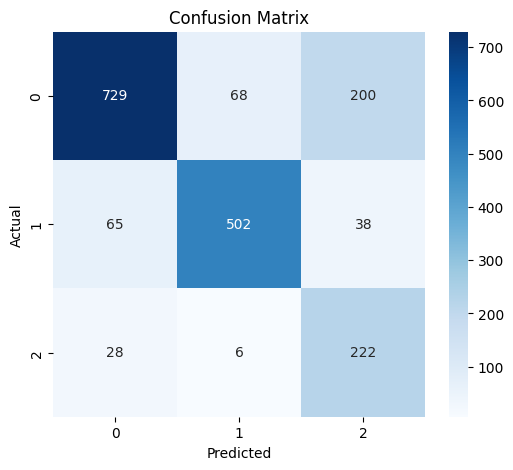

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Accuracy Score,▁
Macro F1-score,▁
Micro F1-score,▁
Accuracy Score,0.78202
Macro F1-score,0.75726
Micro F1-score,0.78202


In [6]:
# Initialize and train model
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

wandb.init(entity='cs4248-nlp-project',project=f"{project_name}-{dataset}", name="logistic-regression")
common.evaluate(y_test, y_pred, label_encoder, "Logistic Regression")
wandb.finish()

## 4. Train Random Forest Classifier

Random Forest Classifier
-----Evaluation-----
Accuracy: 0.8175
Macro F1-score: 0.7949
Micro F1-score: 0.8175


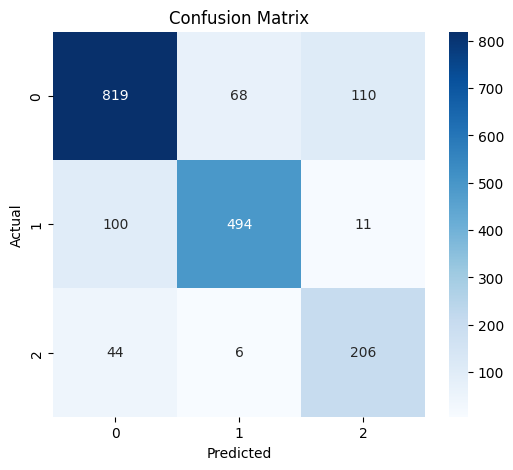

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Accuracy Score,▁
Macro F1-score,▁
Micro F1-score,▁
Accuracy Score,0.81755
Macro F1-score,0.7949
Micro F1-score,0.81755


In [7]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

wandb.init(entity='cs4248-nlp-project',project=f"{project_name}-{dataset}", name="random-forest-classifier")
common.evaluate(y_test, y_pred_rf, label_encoder, "Random Forest Classifier")
wandb.finish()

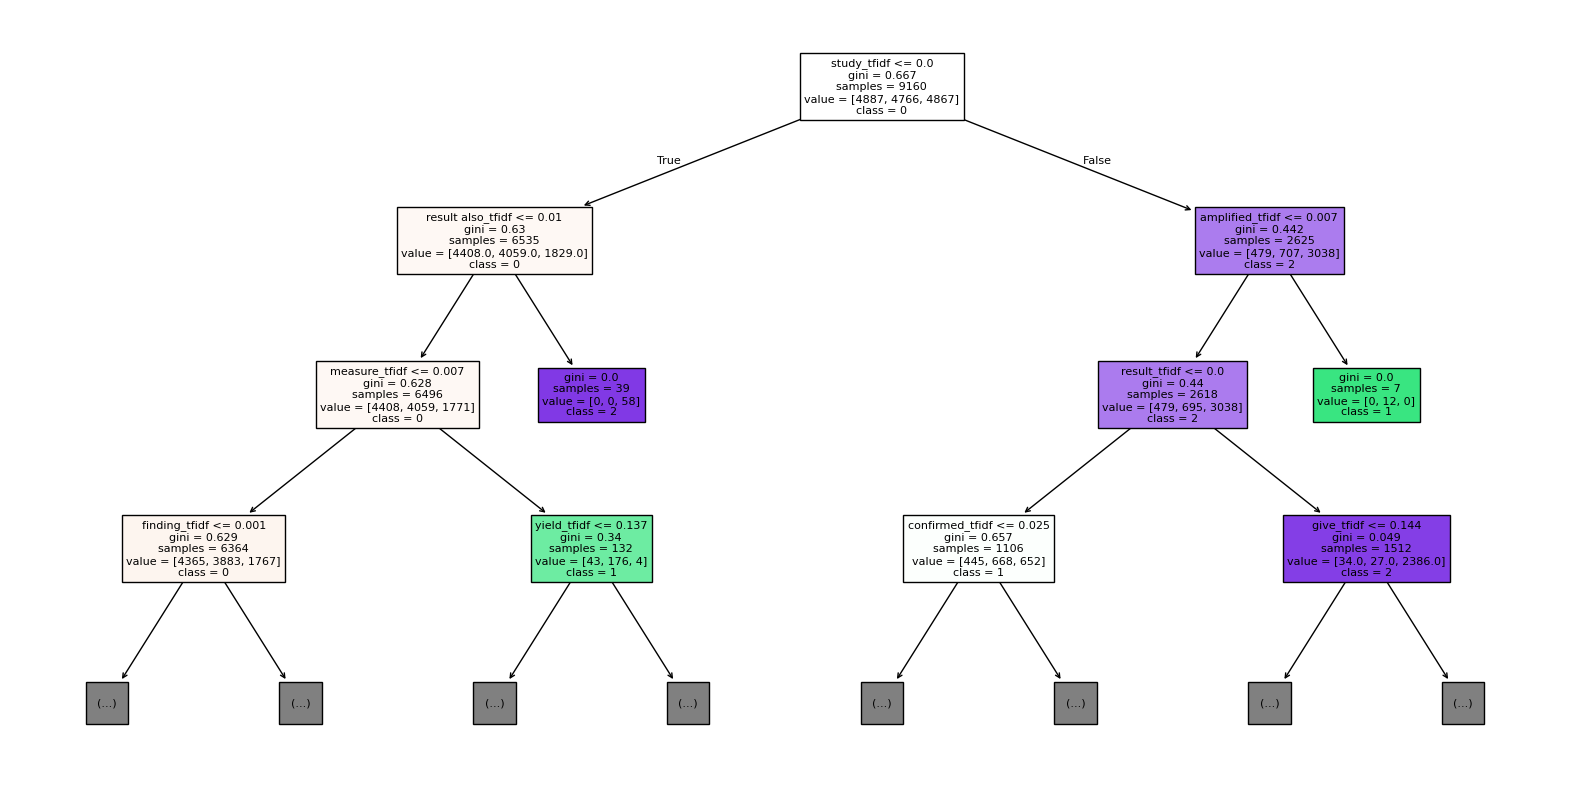

In [8]:
tree_index = 0
plt.figure(figsize=(20, 10))  # Adjust figure size for readability
class_names = [str(cls) for cls in rf_model.classes_]
class_names = class_names[0:5]
plot_tree(rf_model.estimators_[tree_index], feature_names=X_train.columns, class_names=class_names, filled=True, max_depth=3)
plt.show()

## 5. Train Support Vector Machine (SVM)

Support Vector Machine (SVM)
-----Evaluation-----
Accuracy: 0.4548
Macro F1-score: 0.3970
Micro F1-score: 0.4548


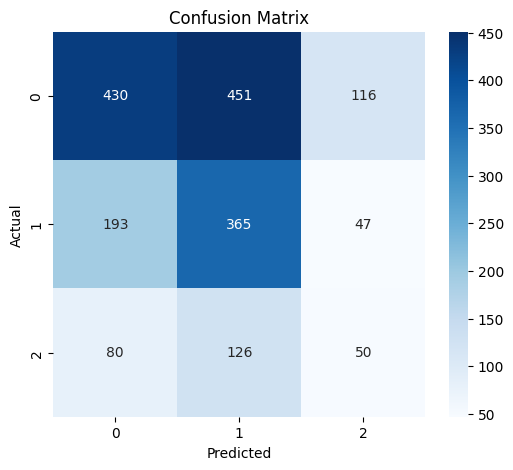

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Accuracy Score,▁
Macro F1-score,▁
Micro F1-score,▁
Accuracy Score,0.45479
Macro F1-score,0.39699
Micro F1-score,0.45479


In [9]:
svm_model = SVC()
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

wandb.init(entity='cs4248-nlp-project',project=f"{project_name}-{dataset}", name="support-vector-machine")
common.evaluate(y_test, y_pred_svm, label_encoder, "Support Vector Machine (SVM)")
wandb.finish()

# 6. Essemble Classifier

In [10]:
estimators=[ 
        ('logistic', model),
        ('svm',svm_model),
        ('random_forest', rf_model)
        ]

Trained-ensemble(log,svm,rf)_log_prefit
-----Evaluation-----
Accuracy: 0.8116
Macro F1-score: 0.7890
Micro F1-score: 0.8116


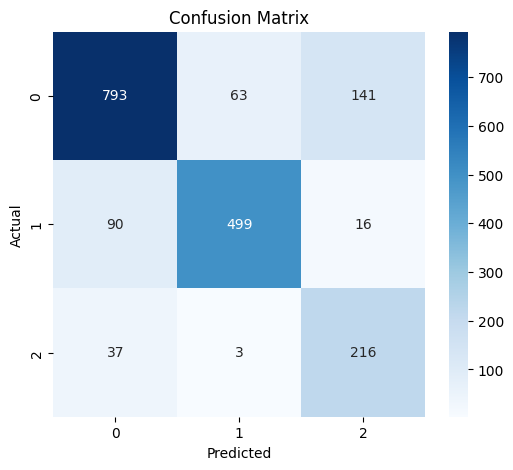

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Accuracy Score,▁
Macro F1-score,▁
Micro F1-score,▁
Accuracy Score,0.81163
Macro F1-score,0.78904
Micro F1-score,0.81163


In [11]:
# Define stacking classifier with pre-trained models
stacking_clf = StackingClassifier(
    estimators= estimators,
    final_estimator=LogisticRegression(max_iter=10000),
    passthrough=False, 
    cv='prefit',  # Cross-validation for meta-classifier training
    stack_method="auto",  # Uses "predict_proba" or "decision_function" if available
    verbose=1
)

# Train the stacking classifier
stacking_clf.fit(X_train, y_train)

# Make predictions
y_pred = stacking_clf.predict(X_test)

# Evaluate the model
wandb.init(entity='cs4248-nlp-project',project=f"{project_name}-{dataset}", name="Trained-ensemble(log,svm,rf)_log_prefit")
common.evaluate(y_test, y_pred, label_encoder, "Trained-ensemble(log,svm,rf)_log_prefit")
wandb.finish()